In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow import keras

tf.random.set_seed(3407)
np.random.seed(3407)
random.seed(3407)

from create_spectrogram import create_spectrograms_from_audio_dataset
from helper_functions import (
    convert_bytes,
    convert_prefetchdataset_to_numpy_arrays,
    evaluate_prediction,
    evaluate_time_of_prediction,
    get_file_size,
    predict_and_print_full_results,
)

2024-08-27 22:31:59.314117: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 22:31:59.579576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 22:31:59.579622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 22:31:59.623717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 22:31:59.721045: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 22:31:59.722435: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [25]:
train_dataset = tf.keras.utils.audio_dataset_from_directory(
    "../dataset/training",
    labels="inferred",
    sampling_rate=16000,
    batch_size=32,
    shuffle=True,
    seed=3407,
)
test_dataset = tf.keras.utils.audio_dataset_from_directory(
    "../dataset/testing",
    labels="inferred",
    sampling_rate=16000,
    batch_size=32,
    shuffle=True,
    seed=3407,
)
val_dataset = tf.keras.utils.audio_dataset_from_directory(
    "../dataset/validation",
    labels="inferred",
    sampling_rate=16000,
    batch_size=32,
    shuffle=True,
    seed=3407,
)

label_names = np.array(train_dataset.class_names)
print("Classes: ", label_names)

Found 11292 files belonging to 2 classes.
Found 1393 files belonging to 2 classes.
Found 1380 files belonging to 2 classes.
Classes:  ['non_target' 'target']


In [26]:
train_spectrogram_ds = (
    create_spectrograms_from_audio_dataset(train_dataset, sample_rate=16000)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
test_spectrogram_ds = (
    create_spectrograms_from_audio_dataset(test_dataset, sample_rate=16000)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
val_spectrogram_ds = (
    create_spectrograms_from_audio_dataset(val_dataset, sample_rate=16000)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds)
x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)
x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_spectrogram_ds)

tf.Tensor([0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0], shape=(32,), dtype=int32)
0
tf.Tensor([0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
0
tf.Tensor([1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0], shape=(32,), dtype=int32)
1


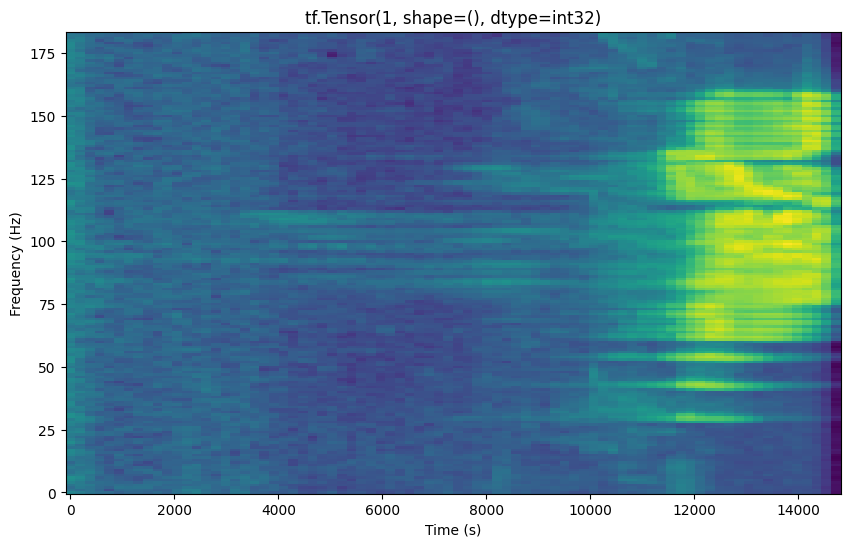

In [27]:
# non-target = 0, target = 1
# Print spectrograms of target or non-target class from dataset
class_number = 1

for i in train_spectrogram_ds:
    print(i[1])
    print(i[1][0].numpy())
    if i[1][0].numpy() == class_number:
        spectrogram = i[0][0]
        height = spectrogram.shape[0]
        width = spectrogram.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(X, Y, spectrogram)
        plt.title(i[1][0])
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.show()
        break

### HPO

In [147]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes, num_of_layers):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_of_conv_layers = num_of_layers

    def build(self, hp):
        model = tf.keras.Sequential()

        # Hyperparameters
        kernel_size = hp.Choice("kernel_size", values=[2, 3, 5])
        dense_units = hp.Int("1st_dense_units", min_value=4, max_value=32, step=4)
        dense_activation = hp.Choice(
            "2nd_dense_activation", values=["softmax", "sigmoid"]
        )
        learning_rate = hp.Float(
            "learning_rate", min_value=1e-4, max_value=1e-2, sampling="log"
        )

        # Model architecture
        model.add(tf.keras.layers.Input(shape=self.input_shape))

        # Tune number of layers
        for i in range(self.num_of_conv_layers):
            model.add(
                tf.keras.layers.Conv2D(
                    filters=hp.Int(f"filters_{i}", min_value=2, max_value=8, step=2),
                    kernel_size=(kernel_size, kernel_size),
                    activation=hp.Choice("conv2d_activation", ["relu", "tanh"]),
                )
            )
            model.add(tf.keras.layers.MaxPooling2D((2, 2)))

        model.add(tf.keras.layers.Flatten())

        model.add(tf.keras.layers.Dense(units=dense_units, activation="relu"))

        model.add(
            tf.keras.layers.Dense(units=self.num_classes, activation=dense_activation)
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"],
        )
        return model

#### Tune 1 conv2d layer CNN

In [148]:
input_shape = (184, 80, 1)
num_classes = 2

num_of_conv_layers = 1
tuner_1_layer_cnn = RandomSearch(
    CNNHyperModel(input_shape, num_classes, num_of_conv_layers),
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=2,
    directory="hpo_tuner/cnn",
    project_name="cnn_1_conv2d_tuning",
)
tuner_1_layer_cnn.search(
    train_spectrogram_ds, epochs=10, validation_data=val_spectrogram_ds
)
tuner_1_layer_cnn.results_summary()

Trial 20 Complete [00h 04m 22s]
val_accuracy: 0.9818840622901917

Best val_accuracy So Far: 0.9876811802387238
Total elapsed time: 01h 04m 53s
Results summary
Results in hpo_tuner/cnn/cnn_1_conv2d_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 18 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 32
2nd_dense_activation: softmax
learning_rate: 0.002910285815853156
filters_0: 4
conv2d_activation: relu
Score: 0.9876811802387238

Trial 02 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 20
2nd_dense_activation: softmax
learning_rate: 0.0017756127466446612
filters_0: 4
conv2d_activation: relu
Score: 0.9873188436031342

Trial 12 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 32
2nd_dense_activation: softmax
learning_rate: 0.00033760108458835025
filters_0: 4
conv2d_activation: relu
Score: 0.9858695864677429

Trial 01 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 32
2nd_dense_activation: sigmoid
learning_rate: 0.00017393

#### Tune 2 conv2d layers CNN

In [165]:
num_of_layers = 2
tuner_2_layer_cnn = RandomSearch(
    CNNHyperModel(input_shape, num_classes, num_of_layers),
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=2,
    directory="hpo_tuner/cnn",
    project_name="cnn_2_conv2d_tuning",
)
tuner_2_layer_cnn.search(
    train_spectrogram_ds, epochs=10, validation_data=val_spectrogram_ds
)
tuner_2_layer_cnn.results_summary()

Trial 20 Complete [00h 05m 21s]
val_accuracy: 0.9742753505706787

Best val_accuracy So Far: 0.9931159317493439
Total elapsed time: 01h 18m 22s
Results summary
Results in hpo_tuner/cnn/cnn_2_conv2d_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 28
2nd_dense_activation: softmax
learning_rate: 0.0002630359449493652
filters_0: 6
conv2d_activation: relu
filters_1: 6
Score: 0.9931159317493439

Trial 04 summary
Hyperparameters:
kernel_size: 3
1st_dense_units: 24
2nd_dense_activation: sigmoid
learning_rate: 0.002475356923928745
filters_0: 4
conv2d_activation: relu
filters_1: 6
Score: 0.9913043677806854

Trial 06 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 24
2nd_dense_activation: sigmoid
learning_rate: 0.0012928388435949555
filters_0: 8
conv2d_activation: relu
filters_1: 8
Score: 0.9887681305408478

Trial 02 summary
Hyperparameters:
kernel_size: 3
1st_dense_units: 4
2nd_dense_activati

#### Tune 3 conv2d layers CNN

In [166]:
num_of_layers = 3
tuner_3_layer_cnn = RandomSearch(
    CNNHyperModel(input_shape, num_classes, num_of_layers),
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory="hpo_tuner/cnn",
    project_name="cnn_3_conv2d_tuning",
)
tuner_3_layer_cnn.search(
    train_spectrogram_ds, epochs=10, validation_data=val_spectrogram_ds
)
tuner_3_layer_cnn.results_summary()

Trial 10 Complete [00h 04m 02s]
val_accuracy: 0.9786232113838196

Best val_accuracy So Far: 0.9923912882804871
Total elapsed time: 00h 46m 35s
Results summary
Results in hpo_tuner/cnn/cnn_3_conv2d_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 20
2nd_dense_activation: sigmoid
learning_rate: 0.003449485159787074
filters_0: 8
conv2d_activation: relu
filters_1: 6
filters_2: 8
Score: 0.9923912882804871

Trial 06 summary
Hyperparameters:
kernel_size: 2
1st_dense_units: 32
2nd_dense_activation: softmax
learning_rate: 0.0010411176939887003
filters_0: 8
conv2d_activation: relu
filters_1: 8
filters_2: 4
Score: 0.9913043677806854

Trial 05 summary
Hyperparameters:
kernel_size: 5
1st_dense_units: 28
2nd_dense_activation: softmax
learning_rate: 0.0013207758153130377
filters_0: 2
conv2d_activation: relu
filters_1: 2
filters_2: 6
Score: 0.9894927442073822

Trial 00 summary
Hyperparameters:
kernel_size: 

In [167]:
tuner_1_layer_cnn.search_space_summary()

Search space summary
Default search space size: 6
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 5], 'ordered': True}
1st_dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
2nd_dense_activation (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
conv2d_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}


In [168]:
tuner_2_layer_cnn.search_space_summary()

Search space summary
Default search space size: 7
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 5], 'ordered': True}
1st_dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
2nd_dense_activation (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
conv2d_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}


In [169]:
tuner_3_layer_cnn.search_space_summary()

Search space summary
Default search space size: 8
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 5], 'ordered': True}
1st_dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
2nd_dense_activation (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
conv2d_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}


Print the best hyperparameters

In [170]:
best_hps = tuner_2_layer_cnn.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
kernel_size: 5
1st_dense_units: 28
2nd_dense_activation: softmax
learning_rate: 0.0002630359449493652
filters_0: 6
conv2d_activation: relu
filters_1: 6


We will use ... models, that showed good (or best) results in HPO

#### Model 1

In [ ]:
# Trial 02 summary
# Hyperparameters:
# kernel_size: 5
# 1st_dense_units: 20
# 2nd_dense_activation: softmax
# learning_rate: 0.0017756127466446612
# filters_0: 4
# conv2d_activation: relu
# Score: 0.9873188436031342

In [178]:
model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(184, 80, 1)),
        tf.keras.layers.Conv2D(4, (5, 5), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 76, 4)        104       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 38, 4)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 13680)             0         
                                                                 
 dense_7 (Dense)             (None, 20)                273620    
                                                                 
 dense_8 (Dense)             (None, 2)                 42        
                                                                 
Total params: 273766 (1.04 MB)
Trainable params: 273766 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [179]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0017756127466446612),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


# EPOCHS = 1
EPOCHS = 15
history = model_1.fit(train_spectrogram_ds, epochs=EPOCHS)

Epoch 1/15


353/353 [==============================] - 11s 29ms/step - loss: 0.1664 - accuracy: 0.9408
Epoch 2/15
353/353 [==============================] - 10s 29ms/step - loss: 0.0822 - accuracy: 0.9694
Epoch 3/15
353/353 [==============================] - 10s 29ms/step - loss: 0.0362 - accuracy: 0.9885
Epoch 4/15
353/353 [==============================] - 10s 28ms/step - loss: 0.0164 - accuracy: 0.9951
Epoch 5/15
353/353 [==============================] - 10s 28ms/step - loss: 0.0071 - accuracy: 0.9981
Epoch 6/15
353/353 [==============================] - 10s 29ms/step - loss: 0.0188 - accuracy: 0.9949
Epoch 7/15
353/353 [==============================] - 10s 28ms/step - loss: 0.0155 - accuracy: 0.9950
Epoch 8/15
353/353 [==============================] - 10s 29ms/step - loss: 0.0210 - accuracy: 0.9934
Epoch 9/15
353/353 [==============================] - 10s 29ms/step - loss: 0.0177 - accuracy: 0.9953
Epoch 10/15
353/353 [==============================] - 10s 29ms/step - loss: 0.0027 - accurac

In [180]:
print("Validation dataset accuracy:")
val_loss, val_acc = model_1.evaluate(x_val_np, y_val_np)

Validation dataset accuracy:
44/44 [==============================] - 1s 10ms/step - loss: 0.1082 - accuracy: 0.9884


In [181]:
print("Validation dataset:")
(
    y_pred_val,
    non_overlap_patritions_f1_scores_val,
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_1, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test,
    non_overlap_patritions_f1_scores_test,
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_1, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(
    model_1, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True
)

Validation dataset:
44/44 [==============================] - 0s 10ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.84%
Recall: 97.88%
Precision: 98.72%
F1-score: 98.30%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9830047649448164

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9802888168895098

Test dataset:
44/44 [==============================] - 0s 9ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.85%
Recall: 98.91%
Precision: 97.63%
F1-score: 98.26%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9824629846044427

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9797155001965676
Time of one prediction for Test dataset:
Accuracy: 98.85%
Recall: 98.91%
P

In [182]:
MODEL_FILE_NAME = (
    "spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_1_conv_layer_model.keras"
)
model_1.save(MODEL_FILE_NAME)
print("Model file name: ", MODEL_FILE_NAME)
convert_bytes(get_file_size(MODEL_FILE_NAME), "MB")

Model file name:  spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_1_conv_layer_model.keras
File size: 3.162 Megabytes


1 layer CNN is too big. We dont have second MaxPooling

#### Model 2

In [171]:
# Trial 09 summary
# Hyperparameters:
# kernel_size: 5
# 1st_dense_units: 28
# 2nd_dense_activation: softmax
# learning_rate: 0.0002630359449493652
# filters_0: 6
# conv2d_activation: relu
# filters_1: 6
# Score: 0.9931159317493439

In [185]:
model_2 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(184, 80, 1)),
        tf.keras.layers.Conv2D(6, (5, 5), activation="relu"),
        tf.keras.layers.Input(shape=(184, 80, 1)),
        tf.keras.layers.Conv2D(6, (5, 5), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(28, activation="relu"),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)

model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 180, 76, 6)        156       
                                                                 
 input_11 (InputLayer)       multiple                  0         
                                                                 
 conv2d_12 (Conv2D)          (None, 176, 72, 6)        906       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 88, 36, 6)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 19008)             0         
                                                                 
 dense_11 (Dense)            (None, 28)                532252    
                                                      

In [186]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002630359449493652),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


# EPOCHS = 1
EPOCHS = 15
history = model_2.fit(train_spectrogram_ds, epochs=EPOCHS)

print("Validation dataset accuracy:")
val_loss, val_acc = model_2.evaluate(x_val_np, y_val_np)

Epoch 1/15


353/353 [==============================] - 48s 136ms/step - loss: 0.1939 - accuracy: 0.9213
Epoch 2/15
353/353 [==============================] - 47s 134ms/step - loss: 0.0921 - accuracy: 0.9660
Epoch 3/15
353/353 [==============================] - 47s 133ms/step - loss: 0.0595 - accuracy: 0.9790
Epoch 4/15
353/353 [==============================] - 47s 134ms/step - loss: 0.0404 - accuracy: 0.9857
Epoch 5/15
353/353 [==============================] - 49s 140ms/step - loss: 0.0276 - accuracy: 0.9903
Epoch 6/15
353/353 [==============================] - 49s 139ms/step - loss: 0.0225 - accuracy: 0.9924
Epoch 7/15
353/353 [==============================] - 48s 136ms/step - loss: 0.0124 - accuracy: 0.9960
Epoch 8/15
353/353 [==============================] - 50s 141ms/step - loss: 0.0104 - accuracy: 0.9974
Epoch 9/15
353/353 [==============================] - 50s 141ms/step - loss: 0.0075 - accuracy: 0.9976
Epoch 10/15
353/353 [==============================] - 48s 137ms/step - loss: 0.0053

In [187]:
print("Validation dataset:")
(
    y_pred_val,
    non_overlap_patritions_f1_scores_val,
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_2, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test,
    non_overlap_patritions_f1_scores_test,
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_2, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(
    model_2, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True
)

Validation dataset:
44/44 [==============================] - 1s 20ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.48%
Recall: 98.73%
Precision: 96.88%
F1-score: 97.80%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.978056395943109

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9768650762007334

Test dataset:
44/44 [==============================] - 1s 21ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.42%
Recall: 99.78%
Precision: 95.61%
F1-score: 97.65%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9757255188224552

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9770872364037699
Time of one prediction for Test dataset:
Accuracy: 98.42%
Recall: 99.78%
P

In [188]:
MODEL_FILE_NAME = (
    "spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_2_conv_layer_model.keras"
)
model_2.save(MODEL_FILE_NAME)
print("Model file name: ", MODEL_FILE_NAME)
convert_bytes(get_file_size(MODEL_FILE_NAME), "MB")

Model file name:  spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_2_conv_layer_model.keras
File size: 6.14 Megabytes


### Model 3

In [189]:
# kernel_size: 2
# 1st_dense_units: 20
# 2nd_dense_activation: sigmoid
# learning_rate: 0.003449485159787074
# filters_0: 8
# conv2d_activation: relu
# filters_1: 6
# filters_2: 8
# Score: 0.9923912882804871

In [190]:
model_3 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(184, 80, 1)),
        tf.keras.layers.Conv2D(8, (2, 2), activation="relu"),
        tf.keras.layers.Input(shape=(184, 80, 1)),
        tf.keras.layers.Conv2D(6, (2, 2), activation="relu"),
        tf.keras.layers.Input(shape=(184, 80, 1)),
        tf.keras.layers.Conv2D(8, (2, 2), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(2, activation="sigmoid"),
    ]
)

model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 183, 79, 8)        40        
                                                                 
 input_13 (InputLayer)       multiple                  0         
                                                                 
 conv2d_14 (Conv2D)          (None, 182, 78, 6)        198       
                                                                 
 input_14 (InputLayer)       multiple                  0         
                                                                 
 conv2d_15 (Conv2D)          (None, 181, 77, 8)        200       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 38, 8)         0         
 g2D)                                                            
                                                      

In [191]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003449485159787074),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


# EPOCHS = 1
EPOCHS = 15
history = model_3.fit(train_spectrogram_ds, epochs=EPOCHS)

print("Validation dataset accuracy:")
val_loss, val_acc = model_3.evaluate(x_val_np, y_val_np)

Epoch 1/15


/home/polina/newname/.venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 25s 70ms/step - loss: 0.1474 - accuracy: 0.9468
Epoch 2/15
353/353 [==============================] - 22s 63ms/step - loss: 0.0427 - accuracy: 0.9843
Epoch 3/15
353/353 [==============================] - 22s 61ms/step - loss: 0.0302 - accuracy: 0.9907
Epoch 4/15
353/353 [==============================] - 22s 63ms/step - loss: 0.0147 - accuracy: 0.9951
Epoch 5/15
353/353 [==============================] - 24s 68ms/step - loss: 0.0165 - accuracy: 0.9952
Epoch 6/15
353/353 [==============================] - 24s 68ms/step - loss: 0.0098 - accuracy: 0.9971
Epoch 7/15
353/353 [==============================] - 22s 62ms/step - loss: 0.0086 - accuracy: 0.9976
Epoch 8/15
353/353 [==============================] - 24s 68ms/step - loss: 0.0030 - accuracy: 0.9997
Epoch 9/15
353/353 [==============================] - 24s 67ms/step - loss: 1.9881e-04 - accuracy: 1.0000
Epoch 10/15
353/353 [==============================] - 22s 62ms/step - loss: 5.5334e-05 -

In [192]:
print("Validation dataset:")
(
    y_pred_val,
    non_overlap_patritions_f1_scores_val,
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model_3, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test,
    non_overlap_patritions_f1_scores_test,
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_3, x_test_np, y_test_np, model_format="keras")

print("Time of one prediction for Test dataset:")
evaluate_time_of_prediction(
    model_3, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True
)

Validation dataset:
44/44 [==============================] - 1s 15ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 99.20%
Recall: 98.94%
Precision: 98.73%
F1-score: 98.84%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9881530635879152

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9882050216658658

Test dataset:
44/44 [==============================] - 1s 15ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.42%
Recall: 98.25%
Precision: 96.98%
F1-score: 97.61%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9760170625211165

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9748488531146403
Time of one prediction for Test dataset:
Accuracy: 98.35%
Recall: 98.03%


In [193]:
MODEL_FILE_NAME = (
    "spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_3_conv_layer_model.keras"
)
model_3.save(MODEL_FILE_NAME)
print("Model file name: ", MODEL_FILE_NAME)
convert_bytes(get_file_size(MODEL_FILE_NAME), "MB")

Model file name:  spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_3_conv_layer_model.keras
File size: 6.311 Megabytes


#### Final model

All best tuned models are too big. We try to make final model much smaller and keep high af1 score level

We keep relu and softmax as in tuned models but reduce number of filters and kernel size. After manual tuning we get this model:

We took 2 layers model because in this case we can do pooling two times so in first dense layer we dont have too many neurons and also model has not that many filters as 3 layers model

In [28]:
num_labels = len(label_names)
print("Number of classes:", num_labels)

model = keras.Sequential(
    [
        keras.layers.Input(shape=(184, 80, 1)),
        keras.layers.Conv2D(4, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(4, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Reshape((44 * 18 * 4,)),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(num_labels, activation="softmax"),
    ]
)

model.summary()

Number of classes: 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 182, 78, 4)        40        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 91, 39, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 89, 37, 4)         148       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 44, 18, 4)         0         
 g2D)                                                            
                                                                 
 reshape_1 (Reshape)         (None, 3168)              0         
                                                                 
 dense_2 (Dense)             (Non

In [29]:
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


# EPOCHS = 1
EPOCHS = 15
history = model.fit(train_spectrogram_ds, epochs=EPOCHS)

Epoch 1/15


/home/polina/newname/.venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 12s 31ms/step - loss: 0.2314 - accuracy: 0.9052
Epoch 2/15
353/353 [==============================] - 10s 29ms/step - loss: 0.1136 - accuracy: 0.9554
Epoch 3/15
353/353 [==============================] - 10s 28ms/step - loss: 0.0740 - accuracy: 0.9717
Epoch 4/15
353/353 [==============================] - 11s 31ms/step - loss: 0.0566 - accuracy: 0.9796
Epoch 5/15
353/353 [==============================] - 11s 32ms/step - loss: 0.0418 - accuracy: 0.9865
Epoch 6/15
353/353 [==============================] - 12s 35ms/step - loss: 0.0375 - accuracy: 0.9870
Epoch 7/15
353/353 [==============================] - 11s 31ms/step - loss: 0.0283 - accuracy: 0.9902
Epoch 8/15
353/353 [==============================] - 10s 29ms/step - loss: 0.0225 - accuracy: 0.9918
Epoch 9/15
353/353 [==============================] - 10s 27ms/step - loss: 0.0184 - accuracy: 0.9934
Epoch 10/15
353/353 [==============================] - 11s 32ms/step - loss: 0.0189 - accurac

In [30]:
print("Validation dataset:")
(
    y_pred_val,
    non_overlap_patritions_f1_scores_val,
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test,
    non_overlap_patritions_f1_scores_test,
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model, x_test_np, y_test_np, model_format="keras")

Validation dataset:
44/44 [==============================] - 1s 13ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 99.06%
Recall: 99.36%
Precision: 97.91%
F1-score: 98.63%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.986689172446992

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9849647962679836

Test dataset:
 9/44 [=====>........................] - ETA: 0s

2024-07-26 13:34:30.143200: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 82019840 exceeds 10% of free system memory.


44/44 [==============================] - 1s 14ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.99%
Recall: 99.13%
Precision: 97.84%
F1-score: 98.48%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9844262846996378

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9864092038895415


In [10]:
print("For Test dataset:")
evaluate_time_of_prediction(
    model, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True
)

For Test dataset:
Accuracy: 98.99%
Recall: 99.13%
Precision: 97.84%
F1-score: 98.48%

Time to make a prediction for a single data point
Mean: 0.068 seconds
Max: 0.413 seconds
Min: 0.058 seconds


In [5]:
BASE_MODEL_FILE_NAME = (
    "../spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_baseline.keras"
)
# model.save(BASE_MODEL_FILE_NAME)
print("Model file name: ", BASE_MODEL_FILE_NAME)
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

Model file name:  ../spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_baseline.keras
File size: 0.328 Megabytes


In [6]:
model_loaded = tf.keras.models.load_model(BASE_MODEL_FILE_NAME)

2024-08-27 22:32:11.819727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 22:32:11.820150: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 182, 78, 4)        40        
                                                                 
 max_pooling2d (MaxPooling2  (None, 91, 39, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 37, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 18, 4)         0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 3168)              0         
                                                                 
 dense (Dense)               (None, 8)                 2

In [17]:
print("\nTest dataset:")
(
    y_pred_test,
    non_overlap_patritions_f1_scores_test,
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(
    model_loaded, x_test_np, y_test_np, model_format="keras"
)


Test dataset:
 5/44 [==>...........................] - ETA: 0s

2024-07-26 12:57:37.938654: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 82019840 exceeds 10% of free system memory.


44/44 [==============================] - 1s 14ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.99%
Recall: 99.13%
Precision: 97.84%
F1-score: 98.48%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9844262846996378

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9838960089796045


In [18]:
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "KB")

File size: 335.825 Kilobytes
